# Bloomberg data EDA

## Config

In [1]:
MIN_HIGH_REVENUE = 1000  # mln USD
BANKRUPTCY_DATA_VERSION = "4"
CONTROL_DATA_VERSION = None  # None = does not include Control Data

# WARNING: if Control Data is included, it should be consistent with the minimum revenue threshold

## Setup

In [2]:
import datetime as dt
import itertools
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loguru import logger
from pandas.api.types import is_string_dtype, is_numeric_dtype
from scipy.stats import norm

import shap
from lightgbm import LGBMRegressor, LGBMClassifier
from mlutil.eval import TimeSeriesSplit
from mlutil.model import GAM
# from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoLars
from sklearn.metrics import (
    log_loss, accuracy_score, 
    balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, precision_recall_curve, RocCurveDisplay,
    get_scorer_names
)
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(42**3)

In [3]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn-v0_8')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.family'] = 'monospace'

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

In [4]:
def dht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))

In [5]:
def q25(x):
    return np.nanquantile(x, q=0.25)


def q75(x):
    return np.nanquantile(x, q=0.75)

## Data cleaning

### Load data

In [6]:
# --- All bankrupcy data
b_sheets = pd.read_excel(
    f"data/Bankruptcy Data v{BANKRUPTCY_DATA_VERSION}.xlsx", sheet_name=None, header=0, skiprows=1
)
b_sheet_names = list(b_sheets.keys())
print(b_sheet_names)

assert b_sheet_names[0] == "1. Date and Industry"

# Set a quarter (Q1 starts at January 1)
print("\n- compute Bankruptcy Quarter (Q1 starts at January 1)")
_df = b_sheets["1. Date and Industry"]
_df["Bankruptcy Date"] = pd.to_datetime(_df["Bankruptcy Date"], format=r"%m/%d/%Y")
_df["Bankruptcy Quarter"] = (
    _df["Bankruptcy Date"].dt.year.astype(str) 
    + "Q" + ((_df["Bankruptcy Date"].dt.month - 1) // 3 + 1).astype(str)
)
dht(_df)

['1. Date and Industry', 'Revenue', 'EBITDA', 'EBIT', 'Interest Expense', 'Net Income', 'Total Assets', 'ST Debt', 'LT Debt', 'Equity', 'Inventories', 'Acc Receivable', 'Acc Payable', 'Cash']

- compute Bankruptcy Quarter (Q1 starts at January 1)


,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4
3059,BRADLEES INC,1995-06-23,Discount Stores,914.93M,783.56M,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2
3060,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50M,01.68B,1828306D US Equity,68830710,Communications,10,1900Q3


In [7]:
# --- Aux function to fix control quarter columns
def fix_control_quarters_columns(df: pd.DataFrame) -> None:
    old_qcols = [x for x in df.columns if (len(x.split(":")) == 3) and (x[-2] == "Q")]
    new_qcols = [x[-2:] + " " + x[-5:-3] for x in old_qcols]
    assert all(len(x) == 5 for x in new_qcols)
    df.rename(columns=dict(zip(old_qcols, new_qcols)), inplace=True)
    for col in new_qcols:
        df[col] /= 1000000
    

_df = pd.DataFrame({
    "Ticker": ["ADD", "BDD"], 
    "Q3 21": [0, 1.3], 
    "Revenue:2021:Q4": [1200000, 1340000],
})
_df_expected = pd.DataFrame({
    "Ticker": ["ADD", "BDD"], 
    "Q3 21": [0, 1.3], 
    "Q4 21": [1.2, 1.34],
})
fix_control_quarters_columns(_df)
pd.testing.assert_frame_equal(_df, _df_expected)

In [8]:
# --- Clean control data (make consistent with bankruptcy data) ---

if CONTROL_DATA_VERSION is not None:
    c_sheets = pd.read_excel(
        f"data/Control Data v{CONTROL_DATA_VERSION}.xlsx", 
        sheet_name=None, 
        header=0, 
        skiprows=[0, 1, 3],
    )
    c_sheet_names = list(c_sheets.keys())
    print(c_sheet_names)
    
    # Rename sheets
    c_sheets["1. Date and Industry"] = c_sheets.pop("1. Industry")
    c_sheet_names = list(c_sheets.keys())
    print(c_sheet_names)
    assert set(c_sheet_names) == set(b_sheet_names)

    # Fix master df 
    _df = c_sheets["1. Date and Industry"]
    _df.rename(columns={
        "Short Name": "Name",
        "BICS L1 Sect Nm": "Industry Level 1",
        "BICS L1 Sect Cde": "BISC Code lvl1",
    }, inplace=True)
    # _df["Bankruptcy Date"] = "01/01/2050"

    # Fix metrics dfs
    assert c_sheet_names[-1] == "1. Date and Industry"
    for sname in c_sheet_names[:-1]:
        _df = c_sheets[sname]
        _df.rename(columns={"Short Name": "Name"}, inplace=True)
        fix_control_quarters_columns(_df)
        assert all(x.startswith("Q") for x in _df.columns[2:])
        for c in _df.columns[2:]:
            if not is_numeric_dtype(_df[c].dtype):
                print(f"WARNING: {sname} {c} has type {_df[c].dtype}")
                _df[c] = pd.to_numeric(_df[c], errors="coerce")
                
    # Concatenate bankruptcy and controlled data
    sheets = {}
    for sname in b_sheet_names:
        print(f"concatenate {sname}: {len(b_sheets[sname])} + {len(c_sheets[sname])}")
        sheets[sname] = pd.concat((b_sheets[sname], c_sheets[sname]), ignore_index=True)
        
else:
    sheets = b_sheets
    
sheet_names = b_sheet_names
dht(sheets["1. Date and Industry"])
dht(sheets["Revenue"])
dht(sheets["Cash"])

for sname in sheet_names[1:]:
    _df = sheets[sname]
    assert all(x.startswith("Q") for x in _df.columns[3:])
    for c in _df.columns[3:]:
        if not is_numeric_dtype(_df[c].dtype):
            raise TypeError(f"{sname} {c} has type {_df[c].dtype}")

,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4
3059,BRADLEES INC,1995-06-23,Discount Stores,914.93M,783.56M,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2
3060,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50M,01.68B,1828306D US Equity,68830710,Communications,10,1900Q3


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q4 07,Q3 07,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022,4.562,4.286,0.00,0.000,0.000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022,789.429,772.028,713.83,717.919,760.221,634.86,687.588,820.405,764.8,729.426,699.727,720.411,786.389,745.466,714.696,700.527,768.64,786.887,875.731,1037.6,1241.513,884.335,920.887,963.539,1073.697,745.727,735.166,714.128,662.877,654.116,592.848,470.842,584.946,661.319,712.148,658.494,749.82,...,304.582,269.47,257.147,254.409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,IMPERIAL HOLLY CORP,IHKS US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372.273987,372.585999,428.462006,457.153992,466.312988,429.165009,468.598999,487.894989,499.976990,428.997009,471.760986,477.170013,456.087006,414.96701,434.867004
766,AMERICAN HOMESTAR CORP,HSTRQ US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.322998,139.113007,130.354996,138.789001,165.779007,144.132996,151.399994,169.022003,147.531006,130.727997,117.319000,125.01400,124.732002


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q4 07,Q3 07,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022,26.415,21.953,0.224535,0.408195,0.655371,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022,1507.196,1568.665,1545.172000,1427.775000,1213.437000,1679.738,1780.087,1531.538,1454.531,1526.25,1446.949,981.739,1149.113,1118.885,1098.788,980.412,986.605,738.393,616.534,617.589,517.25,561.577,667.822,221.968,272.348,836.111,2529.735,377.461,405.696,708.529,1427.244,1041.28,526.597,594.085,505.608,340.517,529.689,...,350.325,274.884,445.829,730.857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3059,BRADLEES INC,BLEEQ US Equity,100221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3060,MCCLATCHY CO LLC/THE,1828306D US Equity,68830710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Company, Name, Ticker, Industry, Bankruptcy date

In [9]:
def unify_bloombergs_units(ss: pd.Series) -> pd.Series:
    assert is_string_dtype(ss.dtype)
    numbers = ss.str[:-1].astype(float)
    units = ss.str[-1:]
    unified_numbers = numbers * units.map({"M": 1., "B": 1000., "k": 0.001}).astype(float)
    return unified_numbers


def keep_us_only(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df["Ticker"].str.endswith(" US Equity")].reset_index(drop=True)


def shorten_ticker(tickers: pd.Series) -> pd.Series:
    assert tickers.str.endswith(" Equity").all()
    short_tickers = tickers.str.split(n=1).str[0]
    assert short_tickers.nunique() == tickers.nunique()
    return short_tickers


def encode_quarter(quarters: pd.Series) -> pd.Series:
    assert is_string_dtype(quarters.dtype)
    assert (quarters.isnull() | (quarters.str.len() == 6)).all()
    years = quarters.str[:4].astype(pd.Int64Dtype())
    assert (1970 <= years).all() 
    assert (2050 >= years).all() 
    qs = quarters.str[5].astype(pd.Int64Dtype())
    qs.isin(set([1, 2, 3, 4])) 
    qcodes = years * 4 + (qs - 1)
    assert qcodes.nunique() == quarters.nunique()
    return qcodes


def decode_quarter(qcodes: pd.Series) -> pd.Series:
    assert (7800 < qcodes).all()
    assert (8200 > qcodes).all()
    years = qcodes // 4
    qs = qcodes % 4 + 1
    quarters = years.astype(str) + "Q" + qs.astype(str)
    assert qcodes.nunique() == quarters.nunique()
    return quarters

In [10]:
pd.testing.assert_series_equal(
    unify_bloombergs_units(pd.Series(["13.4M", "1.4B", "90.3k"])),
    pd.Series([13.4, 1400., 0.0903])
)

pd.testing.assert_series_equal(
    shorten_ticker(pd.Series(["0311510Z US Equity", "BLEEQ CN Equity"])),
    pd.Series(["0311510Z", "BLEEQ"])
)

pd.testing.assert_series_equal(
    encode_quarter(pd.Series(["2020Q1", "2021Q1", "2021Q2"])),
    pd.Series([8080, 8084, 8085], dtype=pd.Int64Dtype())
)

pd.testing.assert_series_equal(
    encode_quarter(pd.Series(["2020Q1", "2021Q1", pd.NA])),
    pd.Series([8080, 8084, pd.NA], dtype=pd.Int64Dtype())
)

pd.testing.assert_series_equal(
    decode_quarter(pd.Series([8080, 8084, 8085])),
    pd.Series(["2020Q1", "2021Q1", "2021Q2"])
)

In [11]:
# --- Clean the master sheet (Ticker + Industry + Bankruptcy data)

_df = sheets["1. Date and Industry"]
dht(_df)
print(f"n records = {len(_df)}")

# Remove non-US companies
print("\n- keep US companies only")
_df = keep_us_only(_df)
print(f"n records = {len(_df)}")

# Short ticker name
print("\n- create Short Ticker")
_df["Short Ticker"] = shorten_ticker(_df["Ticker"])

# Uniform format for Assets and Liabilities
print("\n- convert assets and liabilities to M USD")
print(_df["Assets (As of Bankruptcy date)"].str[-1:].value_counts(dropna=False))
print(_df["Liabilities (As of Bankruptcy date)"].str[-1:].value_counts(dropna=False))
_df["Assets (As of Bankruptcy date)"] = unify_bloombergs_units(_df["Assets (As of Bankruptcy date)"])
_df["Liabilities (As of Bankruptcy date)"] = unify_bloombergs_units(_df["Liabilities (As of Bankruptcy date)"])

master_df = _df
dht(master_df)

,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4
3059,BRADLEES INC,1995-06-23,Discount Stores,914.93M,783.56M,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2
3060,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50M,01.68B,1828306D US Equity,68830710,Communications,10,1900Q3


n records = 3061

- keep US companies only
n records = 2983

- create Short Ticker

- convert assets and liabilities to M USD
M      1999
NaN     480
B       391
k       113
Name: Assets (As of Bankruptcy date), dtype: int64
M      2219
B       488
NaN     266
k        10
Name: Liabilities (As of Bankruptcy date), dtype: int64


,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter,Short Ticker
0,VITAL PHARMACEUTICALS INC,2022-10-10,Sports & Energy Drinks,NaN,NaN,0311510Z US Equity,17394873,Consumer Staples,12,2022Q4,0311510Z
1,KABBAGE INC,2022-10-03,Commercial Finance,NaN,NaN,8172566Z US Equity,23987674,Financials,14,2022Q4,8172566Z
2981,BRADLEES INC,1995-06-23,Discount Stores,914.93,783.56,BLEEQ US Equity,100221,Consumer Staples,12,1995Q2,BLEEQ
2982,MCCLATCHY CO LLC/THE,1900-07-01,Newspaper Publishers,946.50,1680.00,1828306D US Equity,68830710,Communications,10,1900Q3,1828306D


In [12]:
# Industries
master_df["Industry Level 1"].value_counts()

Consumer Discretionary    717
Industrials               383
Energy                    290
Communications            258
Health Care               242
Real Estate               241
Financials                234
Materials                 209
Technology                170
Consumer Staples          166
Utilities                  60
Unclassifiable              1
Government                  1
Name: Industry Level 1, dtype: int64

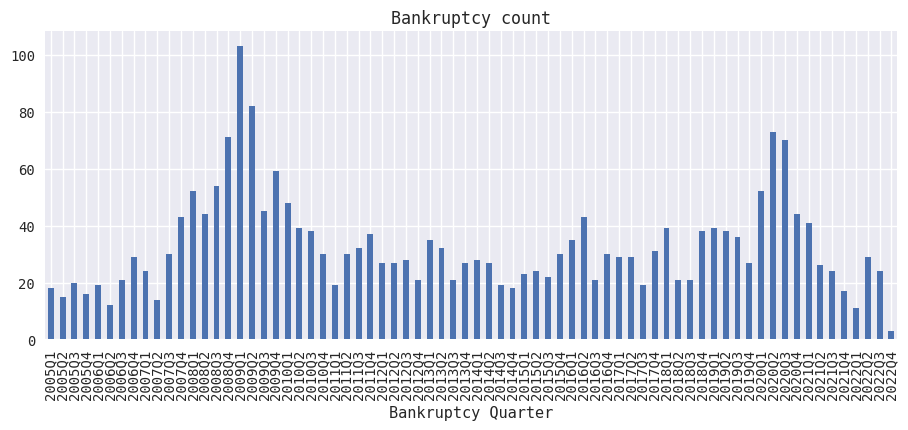

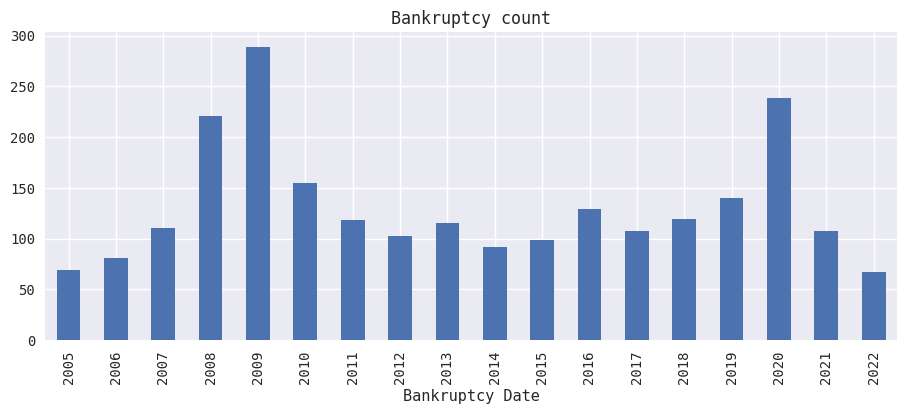

In [13]:
# --- Plot bankruptcy counts ---

plt.figure()
(
    master_df.loc[master_df["Bankruptcy Quarter"] >= "2005"]
    .groupby("Bankruptcy Quarter")["Bankruptcy Quarter"].count()
    .plot(kind="bar", figsize=(11, 4), title="Bankruptcy count")
)
plt.figure()
(
    master_df.loc[master_df["Bankruptcy Quarter"] >= "2005"]
    .groupby(master_df["Bankruptcy Date"].dt.year)["Bankruptcy Date"].count()
    .plot(kind="bar", figsize=(11, 4), title="Bankruptcy count")
)
_ = _

In [14]:
# --- Example of a duplicate (two bunkruptcies of one company)
master_df.loc[master_df["Ticker"] == "HCR US Equity"]

,Name,Bankruptcy Date,Industry (Detailed),Assets (As of Bankruptcy date),Liabilities (As of Bankruptcy date),Ticker,BBID,Industry Level 1,BISC Code lvl1,Bankruptcy Quarter,Short Ticker
281,HI-CRUSH INC,2020-07-12,Oilfield Services & Equipment,953.08,699.14,HCR US Equity,32051410,Energy,13,2020Q3,HCR
652,MANOR CARE INC,2018-03-04,Oilfield Services & Equipment,4260.00,7120.00,HCR US Equity,100719,Energy,13,2018Q1,HCR


In [15]:
# --- Remove companies with multiple bankrupcies (for simplicity) ---

print(f'duplicates: {master_df["Ticker"].duplicated(keep=False).sum()} / {len(master_df)}')
print(f'duplicates: {master_df["Short Ticker"].duplicated(keep=False).sum()} / {len(master_df)}')

print("\ndrop tickers with duplicates")
all_valid_tickers = set(master_df["Short Ticker"].drop_duplicates(keep=False))
print(f"n tickers = {len(all_valid_tickers)}")

duplicates: 100 / 2983
duplicates: 100 / 2983

drop tickers with duplicates
n tickers = 2883


### Filter tickets by revenue

count      730.000000
mean       459.452965
std       2126.440886
min          0.000000
25%         18.261900
50%         84.662514
75%        270.119668
max      42989.444444
Name: Mean Revenue, dtype: float64


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Short Ticker,Mean Revenue
539,OCEAN POWER CORP,PWREQ US Equity,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PWREQ,0.000000
345,FORTICELL BIOSCIENCE INC,FORBQ US Equity,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FORBQ,0.000000
546,SYNERGY TECHNOLOGIES CORP,OILS US Equity,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OILS,0.000000
371,1PM INDUSTRIES INC,OPMZ US Equity,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPMZ,0.000000
102,GASTAR EXPLORATION LTD,GSTC US Equity,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000648,0.000242,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.005901,0.008454,0.006623,0.013133,0.003236,0.019161,0.015119,0.028064,0.021859,0.03221,0.016739,0.002915,0.01375,0.023957,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSTC,0.007067


,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98,Short Ticker,Mean Revenue
357,WASHINGTON MUTUAL INC,WAMUQ US Equity,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6506.0,6549.0,6802.0,6675.0,6513.0,6248.0,5962.0,5314.0,4973.0,4768.0,4283.0,4222.0,3647.0,4047.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WAMUQ,5550.444444
237,AMR CORP,AAMRQ US Equity,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5879.0,5427.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAMRQ,5638.400000
422,DPH HOLDINGS CORP,DPHIQ US Equity,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6779.0,6283.0,7023.0,6862.0,7033.0,6642.0,7549.0,7411.0,7251.0,6558.0,7091.0,7182.0,6971.0,6446.0,7322.0,6688.0,6380.0,6229.0,6944.0,6535.0,6909.0,6648.0,7778.0,7804.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DPHIQ,6929.916667
574,WORLDCOM INC-WORLDCOM GROUP,WCOEQ US Equity,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5078.0,5301.0,5482.0,5362.0,5203.0,9634.0,10037.0,9807.0,9612.0,9989.0,8996.0,9065.0,9122.0,9510.0,3758.0,2581.0,2320.0,WCOEQ,7109.235294
621,KMART CORP/OLD,KMRTQ US Equity,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10878.0,8019.0,8917.0,8337.0,11636.0,8199.0,8998.0,8195.0,11104.0,7962.0,8780.0,8078.0,10401.0,7642.0,8116.0,7515.0,9759.0,7315.0,7846.0,7263.0,KMRTQ,8748.000000
104,SEARS HOLDINGS CORP,SHLDQ US Equity,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4376.0,3575.0,4365.0,4199.0,6052.0,5029.0,5663.0,5394.0,7303.0,5750.0,6211.0,5882.0,8099.0,7207.0,8013.0,7879.0,10593.000,8272.000,8871.000,8452.00,12260.000,8857.000,9467.000,9270.000,12484.000,...,12785.0,11998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SHLDQ,9384.666667
358,LEHMAN BROTHERS HOLDINGS INC,LEHMQ US Equity,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15579.0,13795.0,13160.0,11727.0,11515.0,10307.0,9055.0,8639.0,7335.0,7391.0,5846.0,5051.0,5228.0,5125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEHMQ,9490.368421
192,INVERSIONES ALSACIA SA,1087117D US Equity,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24921.042,24182.305,23727.873,20536.54,22828.299,20193.253,19738.206,18692.258,21962.926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1087117D,21031.016083
635,ENRON CORP,ENE US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Name            FRANKLIN CREDIT HOLDING CORP
Ticker                       FCMCQ US Equity
BCY year                                2012
Q1 12                               2.757013
Q4 11                               3.203024
Q3 11                               3.385199
Q2 11                              52.817992
Q1 11                              34.981141
Q4 10                               5.981583
Q3 10                               4.117724
Q2 10                              12.135293
Q1 10                              19.512042
Q4 09                              14.597854
Q3 09                              20.982985
Q2 09                              14.629757
Q1 09                             -325.51524
Q4 08                              19.716973
Q3 08                              24.119235
Q2 08                              30.878048
Q1 08                              35.215012
Q4 07                              38.025393
Q3 07                              41.563546
Q2 07     

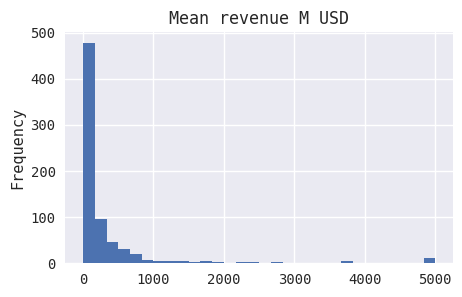

In [16]:
# --- Check revenues ---

_df = sheets["Revenue"].copy()
_df = keep_us_only(_df)
_df["Short Ticker"] = shorten_ticker(_df["Ticker"])
_df = _df.loc[_df["Short Ticker"].isin(all_valid_tickers)].reset_index(drop=True)
assert _df["Short Ticker"].duplicated().sum() == 0
_df["Mean Revenue"] = _df.filter(regex="^Q\d \d\d").mean(axis=1)
print(_df["Mean Revenue"].describe())
display(_df.sort_values("Mean Revenue").head(5))
display(_df.sort_values("Mean Revenue").tail(10))
_df["Mean Revenue"].clip(upper=5000).plot(
    kind="hist", bins=30, figsize=(5, 3), title="Mean revenue M USD"
)
display(_df.loc[_df["Ticker"] == "FCMCQ US Equity"].iloc[0].dropna())
_ = _

In [17]:
def filter_tickers(
    revenue_sheet, tickers, minimum_high_revenue: float = 0, drop_zero_revenue: bool = False
):
    _df = revenue_sheet.copy()
    print(f"n records = {len(_df)}")
    
    # Keep US only
    _df = keep_us_only(_df)
    print(f"n records = {len(_df)}")
    
    # Keep big companies only
    # WARNING: future-looking!
    print(f"- only keep companies with highest revenue > {minimum_high_revenue}M USD")
    _df = _df.loc[_df.iloc[:, 3:].max(axis=1) > minimum_high_revenue].reset_index(drop=True)
    print(f"n records = {len(_df)}")

    # Keep positive revenue only
    if drop_zero_revenue:
        print(f"- only keep companies non-zero revenues")
        _df = _df.loc[~(_df.iloc[:, 3:].abs() < 0.0001).any(axis=1)].reset_index(drop=True)
    print(f"n records = {len(_df)}")
    
    # Short ticker name
    print(f"- intersect revenue and master tickers")
    _df.insert(3, "Short Ticker", shorten_ticker(_df["Ticker"]))
    print("duplicated short tickers:", _df["Short Ticker"].duplicated().sum())

    # Tickers of interest
    new_tickers = tickers & set(_df["Short Ticker"])
    print(f"n tickers of interests = {len(new_tickers)} / {len(tickers)}")
    
    return new_tickers

In [18]:
# --- Filter out tickers with low revenues ---

dht(sheets["Revenue"])
tickers = filter_tickers(
    sheets["Revenue"], all_valid_tickers, minimum_high_revenue=MIN_HIGH_REVENUE, drop_zero_revenue=True
)
print(len(tickers), list(tickers)[:10], "...")

,Name,Ticker,BCY year,Q4 21,Q3 21,Q2 21,Q1 21,Q4 20,Q3 20,Q2 20,Q1 20,Q4 19,Q3 19,Q2 19,Q1 19,Q4 18,Q3 18,Q2 18,Q1 18,Q4 17,Q3 17,Q2 17,Q1 17,Q4 16,Q3 16,Q2 16,Q1 16,Q4 15,Q3 15,Q2 15,Q1 15,Q4 14,Q3 14,Q2 14,Q1 14,Q4 13,Q3 13,Q2 13,Q1 13,Q4 12,...,Q4 07,Q3 07,Q2 07,Q1 07,Q4 06,Q3 06,Q2 06,Q1 06,Q4 05,Q3 05,Q2 05,Q1 05,Q4 04,Q3 04,Q2 04,Q1 04,Q4 03,Q3 03,Q2 03,Q1 03,Q4 02,Q3 02,Q2 02,Q1 02,Q4 01,Q3 01,Q2 01,Q1 01,Q4 00,Q3 00,Q2 00,Q1 00,Q4 99,Q3 99,Q2 99,Q1 99,Q4 98,Q3 98,Q2 98,Q1 98
0,CLARUS THERAPEUTICS HOLDINGS,CRXT US Equity,2022,4.562,4.286,0.00,0.000,0.000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENDO INTERNATIONAL PLC,ENDPQ US Equity,2022,789.429,772.028,713.83,717.919,760.221,634.86,687.588,820.405,764.8,729.426,699.727,720.411,786.389,745.466,714.696,700.527,768.64,786.887,875.731,1037.6,1241.513,884.335,920.887,963.539,1073.697,745.727,735.166,714.128,662.877,654.116,592.848,470.842,584.946,661.319,712.148,658.494,749.82,...,304.582,269.47,257.147,254.409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,IMPERIAL HOLLY CORP,IHKS US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372.273987,372.585999,428.462006,457.153992,466.312988,429.165009,468.598999,487.894989,499.976990,428.997009,471.760986,477.170013,456.087006,414.96701,434.867004
766,AMERICAN HOMESTAR CORP,HSTRQ US Equity,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.322998,139.113007,130.354996,138.789001,165.779007,144.132996,151.399994,169.022003,147.531006,130.727997,117.319000,125.01400,124.732002


n records = 767
n records = 745
- only keep companies with highest revenue > 1000M USD
n records = 83
- only keep companies non-zero revenues
n records = 83
- intersect revenue and master tickers
duplicated short tickers: 0
n tickers of interests = 81 / 2883
81 ['ASNA', 'FLMIQ', 'IHRT', 'AVYA', 'ESVNQ', 'TXU', 'KMRTQ', 'CPNLQ', 'FTR', 'SIRV'] ...


### Revenue and other metrics

In [19]:
# --- Overview of all available metrics ---

for s_name in sheet_names[1:]:
    print(f"{s_name} {sheets[s_name].shape} {sheets[s_name].notnull().sum().sum()}")

Revenue (767, 99) 20191
EBITDA (767, 99) 19164
EBIT (3061, 99) 26698
Interest Expense (3061, 99) 23500
Net Income (3061, 99) 26978
Total Assets (3061, 99) 26885
ST Debt (3061, 99) 26573
LT Debt (3061, 99) 26856
Equity (3061, 99) 26738
Inventories (3061, 99) 25633
Acc Receivable (3061, 99) 26570
Acc Payable (3061, 99) 25225
Cash (3061, 99) 26884


In [20]:
# --- Aux function to transform quarter columns

_year_end_mapping = {"2": "20", "1": "20", "0": "20", "9": "19", "8": "19"}


def rename_quarters_columns(df: pd.DataFrame) -> None:
    old_qcols = [x for x in df.columns if (len(x) == 5) and (x[0] == "Q") and (x[2] == " ")]
    new_qcols = [
        _year_end_mapping[x[-2]] + x[-2:] + x[:2] for x in old_qcols
    ]
    assert all(len(x) == 6 for x in new_qcols)
    df.rename(columns=dict(zip(old_qcols, new_qcols)), inplace=True)
    

_df = pd.DataFrame({"Ticker": ["ADD", "BDD"], "Q3 21": [0, 1.3], "Q4 21": [1.2, 1.34]})
_df_expected = pd.DataFrame({"Ticker": ["ADD", "BDD"], "2021Q3": [0, 1.3], "2021Q4": [1.2, 1.34]})
rename_quarters_columns(_df)
pd.testing.assert_frame_equal(_df, _df_expected)

In [21]:
# --- Transform all the metric spreadsheets ---

wide_sheets = {}
narrow_sheets = {}

for s_name in sheet_names[1:]:
    print(f"-- {s_name} --")
    _df = sheets[s_name].copy()
    print(f"n records = {len(_df)}")
    _df = keep_us_only(_df)
    print(f"n records = {len(_df)}")
    print("duplicates: ", _df["Ticker"].duplicated().sum())
    _df = _df.loc[~(_df["BCY year"] > 2050)].reset_index(drop=True)
    print("duplicates (correct BCY): ", _df["Ticker"].duplicated().sum())
    _df.insert(3, "Short Ticker", shorten_ticker(_df["Ticker"]))
    _df = _df.loc[_df["Short Ticker"].isin(tickers)].reset_index(drop=True)
    _df = _df.iloc[:, 3:].set_index("Short Ticker")
    assert _df.index.is_unique
    rename_quarters_columns(_df)
    print(f"{s_name}: {_df.shape} {_df.notnull().sum().sum()}")
    wide_sheets[s_name] = _df
    _df_melted = _df.reset_index().melt(id_vars="Short Ticker", var_name="Quarter", value_name=s_name)
    assert (_df_melted["Quarter"].str.len() == 6).all()
    _df_melted = _df_melted.set_index(["Short Ticker", "Quarter"])
    assert _df_melted.index.is_unique
    narrow_sheets[s_name] = _df_melted[s_name]
    print(f"{s_name} melted: {_df_melted.shape} {_df_melted.notnull().sum().sum()}")
    
dht(_df)
dht(_df_melted)

-- Revenue --
n records = 767
n records = 745
duplicates:  1
duplicates (correct BCY):  1
Revenue: (81, 96) 2288
Revenue melted: (7776, 1) 2288
-- EBITDA --
n records = 767
n records = 745
duplicates:  1
duplicates (correct BCY):  1
EBITDA: (81, 96) 2180
EBITDA melted: (7776, 1) 2180
-- EBIT --
n records = 3061
n records = 2993
duplicates:  647
duplicates (correct BCY):  1
EBIT: (81, 96) 2228
EBIT melted: (7776, 1) 2228
-- Interest Expense --
n records = 3061
n records = 2993
duplicates:  647
duplicates (correct BCY):  1
Interest Expense: (81, 96) 1844
Interest Expense melted: (7776, 1) 1844
-- Net Income --
n records = 3061
n records = 2993
duplicates:  647
duplicates (correct BCY):  1
Net Income: (81, 96) 2289
Net Income melted: (7776, 1) 2289
-- Total Assets --
n records = 3061
n records = 2993
duplicates:  647
duplicates (correct BCY):  1
Total Assets: (81, 96) 2247
Total Assets melted: (7776, 1) 2247
-- ST Debt --
n records = 3061
n records = 2993
duplicates:  647
duplicates (corr

,2021Q4,2021Q3,2021Q2,2021Q1,2020Q4,2020Q3,2020Q2,2020Q1,2019Q4,2019Q3,2019Q2,2019Q1,2018Q4,2018Q3,2018Q2,2018Q1,2017Q4,2017Q3,2017Q2,2017Q1,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,2015Q1,2014Q4,2014Q3,2014Q2,2014Q1,2013Q4,2013Q3,2013Q2,2013Q1,2012Q4,2012Q3,2012Q2,2012Q1,...,2007Q4,2007Q3,2007Q2,2007Q1,2006Q4,2006Q3,2006Q2,2006Q1,2005Q4,2005Q3,2005Q2,2005Q1,2004Q4,2004Q3,2004Q2,2004Q1,2003Q4,2003Q3,2003Q2,2003Q1,2002Q4,2002Q3,2002Q2,2002Q1,2001Q4,2001Q3,2001Q2,2001Q1,2000Q4,2000Q3,2000Q2,2000Q1,1999Q4,1999Q3,1999Q2,1999Q1,1998Q4,1998Q3,1998Q2,1998Q1
Short Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1507.196,1568.665,1545.172,1427.775,1213.437,1679.738,1780.087,1531.538,1454.531,1526.250,1446.949,981.739,1149.113,1118.885,1098.788,980.412,986.605,738.393,616.534,617.589,517.250,561.577,667.822,221.968,272.348,836.111,2529.735,377.461,405.696,708.529,1427.244,1041.280,526.597,594.085,505.608,340.517,529.689,256.917,391.946,248.303,...,350.325,274.884,445.829,730.857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPNX,NaN,NaN,NaN,NaN,NaN,207.781,278.409,252.221,272.624,259.889,234.132,151.568,158.050,104.690,118.512,90.438,172.000,167.025,177.772,151.766,187.591,278.155,485.847,559.238,564.017,533.674,500.262,414.829,393.046,320.042,201.653,145.848,196.047,90.651,65.399,77.075,91.199,79.086,143.037,135.758,...,51.649,63.809,36.529,31.986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
USG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,493.0,395.0,304.0,35.0,70.0,21.0,18.0,61.0,197.0,273.0,168.0,128.0,152.0,102.0,72.0,66.0
26385Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4341.0,151.0,132.0,154.0,111.0,68.0,84.0,87.0,80.0,84.0,85.0,73.0,NaN,NaN,NaN,NaN


,,Cash
Short Ticker,Quarter,
ENDPQ,2021Q4,1507.196
SPNX,2021Q4,NaN
USG,1998Q1,66.000
26385Z,1998Q1,NaN


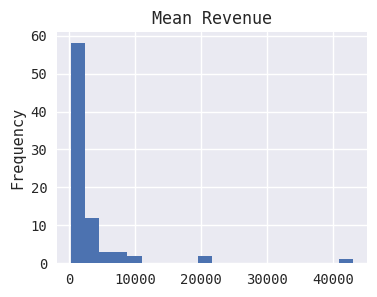

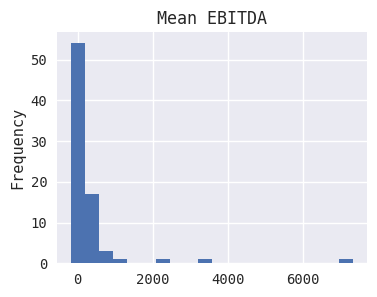

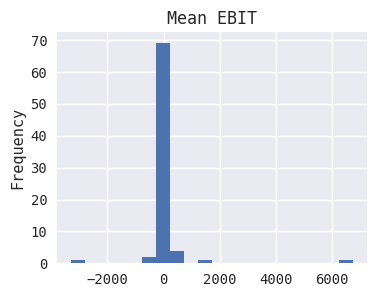

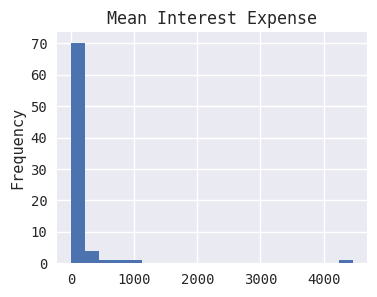

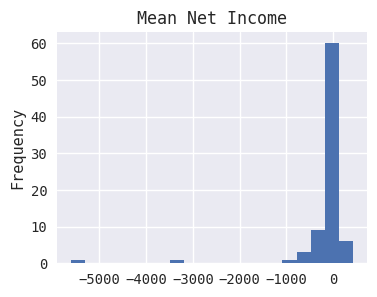

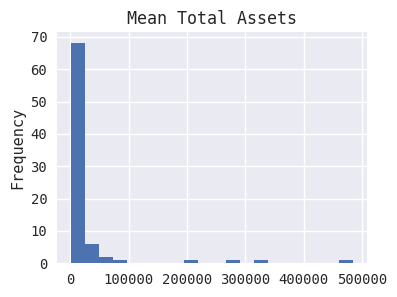

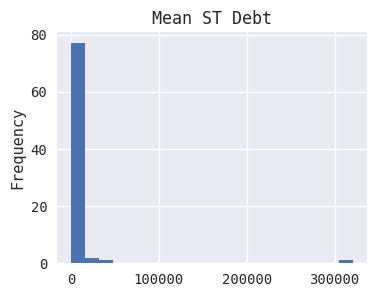

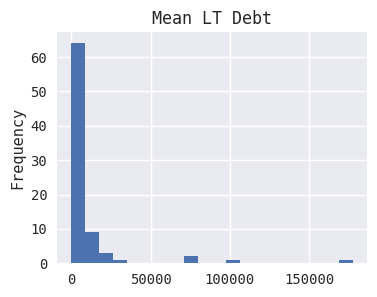

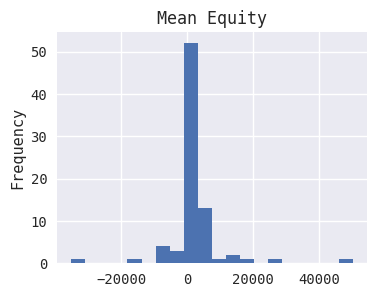

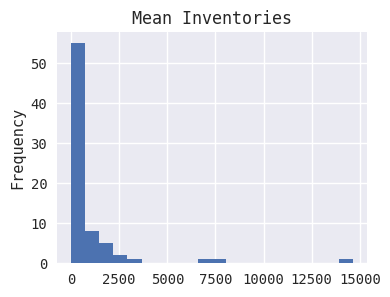

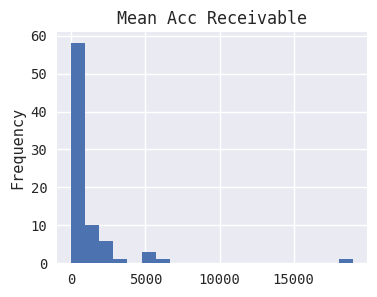

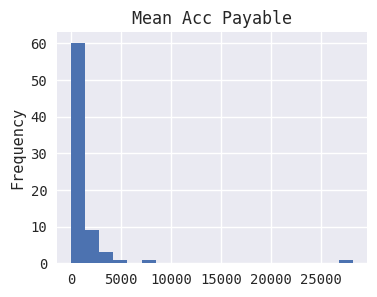

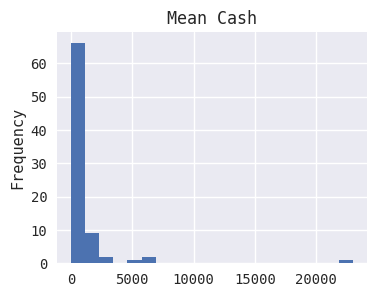

In [22]:
# --- Metric histograms ---

for k, v in wide_sheets.items():
    plt.figure(figsize=(4, 3))
    v.mean(axis=1).plot(kind="hist", bins=20, title=f"Mean {k}")

In [23]:
# --- Weird EBIT-EBITDA cases
(narrow_sheets["EBITDA"] - narrow_sheets["EBIT"]).dropna().sort_values().head(10)

Short Ticker  Quarter
1087117D      2012Q3    -2664.032
LEHMQ         2005Q4     -406.000
578903Z       2010Q2     -165.909
WCOEQ         2001Q4     -145.000
1235274D      2009Q4      -47.228
MIRKQ         2003Q1      -40.000
              2003Q3      -32.000
578903Z       2008Q2      -23.763
NRTLQ         2009Q3      -18.000
NEBLQ         2018Q3      -14.887
dtype: float64

## Putting it all together

### One frame

n records = 7776

n any-valid records = 2293
n all-valid records = 1616

  n valid records:
Revenue             2288
EBITDA              2180
EBIT                2228
Interest Expense    1844
Net Income          2289
Total Assets        2247
ST Debt             2221
LT Debt             2243
Equity              2223
Inventories         2093
Acc Receivable      2219
Acc Payable         2028
Cash                2247
dtype: int64

n records = 7776
n records = 7776
null countdowns = 0 / 7776
null countdowns = 0 / 4346
n records = 4346


Bankruptcy Countdown Bankruptcy Quarter BISC Code lvl1  \
Short Ticker Quarter                                                           
ENDPQ        1998Q1                    -98             2022Q3             16   
             1998Q2                    -97             2022Q3             16   
26385Z       2000Q4                     -2             2001Q2             20   
             2001Q1                     -1             2001Q2             20   

                      Revenue  EBITDA    EBIT  Interest Expense  Net Income  \
Short Ticker Quarter                                                          
ENDPQ        1998Q1       NaN     NaN     NaN               NaN         NaN   
             1998Q2       NaN     NaN     NaN               NaN         NaN   
26385Z       2000Q4    2600.0  1434.0    83.0             184.0     -4156.0   
             2001Q1    2562.0 -1203.0 -1420.0             201.0      -994.0   

                      Total Assets  ST Debt  LT Debt  Equity  Inventories  \
Short Ticker Quarter                                                        
ENDPQ        1998Q1            NaN      NaN      NaN     NaN          NaN   
             1998Q2            NaN      NaN      NaN     NaN          NaN   
26385Z       2000Q4        21988.0   5743.0   5082.0  1847.0        280.0   
             2001Q1        22455.0   5634.0   4978.0   793.0        284.0   

                      Acc Receivable  Acc Payable   Cash  
Short Ticker Quarter                                      
ENDPQ        1998Q1              NaN          NaN    NaN  
             1998Q2              NaN          NaN    NaN  
26385Z       2000Q4           1711.0       3688.0  111.0  
             2001Q1           1574.0       5226.0  154.0

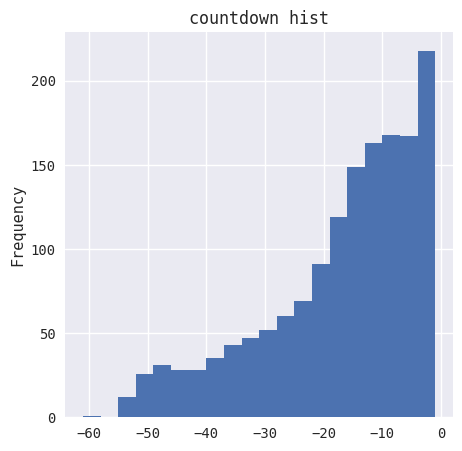

In [24]:
# --- Assemble the frame ---

# Concatenate features
_df = pd.concat(narrow_sheets.values(), axis=1)
print(f"n records = {len(_df)}")

_df = _df.sort_index()
print()
print(f"n any-valid records = {_df.notnull().any(axis=1).sum()}")
print(f"n all-valid records = {_df.notnull().all(axis=1).sum()}")

print("\n  n valid records:")
print(_df.notnull().sum())

# Add bankcruptcy quarter
print()
print(f"n records = {len(_df)}")
_df = pd.merge(
    master_df[[
        "Short Ticker", 
        "Bankruptcy Quarter", 
        # "Bankruptcy Date", 
        "BISC Code lvl1"
    ]],
    _df.reset_index(),
    on=["Short Ticker"],
    how="inner",
)
print(f"n records = {len(_df)}")
_df.insert(
    0, "Bankruptcy Countdown", 
    encode_quarter(_df["Quarter"]) - encode_quarter(_df["Bankruptcy Quarter"])
)
print(f'null countdowns = {_df["Bankruptcy Quarter"].isnull().sum()} / {len(_df)}')

# Filter out records at and after bankruptcy
_df = _df.loc[
    _df["Bankruptcy Countdown"].isnull() | (_df["Bankruptcy Countdown"] < 0)
].reset_index(drop=True)
print(f'null countdowns = {_df["Bankruptcy Quarter"].isnull().sum()} / {len(_df)}')

print(f"n records = {len(_df)}")

_df = _df.set_index(["Short Ticker", "Quarter"])
frame = _df

dht(frame)
_ = frame.dropna()["Bankruptcy Countdown"].plot(kind="hist", bins=20, title="countdown hist")

In [25]:
# --- Check for low metric values ---

for col in ["Revenue", "EBITDA", "Interest Expense"]:
    print(f'zero {col} count = {(frame[col].abs() < 0.0001).sum()}')
    print(f'neg  {col} count = {(frame[col] < -0.0001).sum()}')

zero Revenue count = 0
neg  Revenue count = 2
zero EBITDA count = 1
neg  EBITDA count = 290
zero Interest Expense count = 6
neg  Interest Expense count = 0


In [26]:
# --- Metric history of a random company --- 

_random_tickers = np.random.choice(frame.reset_index()["Short Ticker"].unique(), size=10, replace=False)
print(_random_tickers)
frame.loc[
    (frame.index.get_level_values(0) == _random_tickers[0])
    & frame["Bankruptcy Countdown"].between(-10, 10)
]

['1087117D' 'SDOC' 'CHTRQ' '1235274D' 'DALRQ' 'MNK' 'BLIAQ' 'TOYS' 'MFGLQ' 'LKSD']


Bankruptcy Countdown Bankruptcy Quarter BISC Code lvl1  \
Short Ticker Quarter                                                           
1087117D     2012Q2                    -10             2014Q4             17   
             2012Q3                     -9             2014Q4             17   
             2012Q4                     -8             2014Q4             17   
             2013Q1                     -7             2014Q4             17   
             2013Q2                     -6             2014Q4             17   
             2013Q3                     -5             2014Q4             17   
             2013Q4                     -4             2014Q4             17   
             2014Q1                     -3             2014Q4             17   
             2014Q2                     -2             2014Q4             17   
             2014Q3                     -1             2014Q4             17   

                        Revenue     EBITDA      EBIT  Interest Expense  \
Short Ticker Quarter                                                     
1087117D     2012Q2   19625.350   3573.324  1210.489          5674.532   
             2012Q3   18805.569  -3283.316  -619.284          3439.742   
             2012Q4   21962.926  15340.775  7430.508          3245.087   
             2013Q1   18692.258   1821.894  -725.993          3399.858   
             2013Q2   19738.206   2414.602  -117.575          5244.221   
             2013Q3   20193.253   1399.387 -1157.564          4205.677   
             2013Q4   22828.299   3546.223   937.215          6121.997   
             2014Q1   20536.540   2702.813    79.146          4371.652   
             2014Q2   23727.873   3384.319   758.416          4659.420   
             2014Q3   24182.305        NaN -2432.026               NaN   

                      Net Income  Total Assets    ST Debt     LT Debt  \
Short Ticker Quarter                                                    
1087117D     2012Q2    -5560.648           NaN        NaN         NaN   
             2012Q3     2908.716           NaN        NaN         NaN   
             2012Q4    -1570.669    250419.238  44659.704  190804.541   
             2013Q1    -3422.680    205813.168  33974.314  170223.349   
             2013Q2    -4790.822    227351.986  40855.901  181968.215   
             2013Q3    -4202.402    197912.272  37578.984  166523.617   
             2013Q4    -4148.098    209901.260  48264.641  171618.958   
             2014Q1    -3275.795    189939.764  41116.991  160697.962   
             2014Q2    -2896.200    191816.587  45496.480  162300.760   
             2014Q3   -11214.225           NaN        NaN         NaN   

                         Equity  Inventories  Acc Receivable  Acc Payable  \
Short Ticker Quarter                                                        
1087117D     2012Q2         NaN          NaN             NaN          NaN   
             2012Q3         NaN          NaN             NaN          NaN   
             2012Q4  -18011.237     2000.163        3883.437     5829.226   
             2013Q1  -21433.917     1970.787        5733.980     6831.241   
             2013Q2  -24291.313     1648.067        2559.700     6352.279   
             2013Q3  -28493.715     1171.056        3664.326     5971.656   
             2013Q4  -41241.012     1273.293        7053.804     9078.239   
             2014Q1  -44516.807     1350.586        8850.655    10045.435   
             2014Q2  -47413.008     1688.405        5928.725     8951.089   
             2014Q3         NaN          NaN             NaN          NaN   

                           Cash  
Short Ticker Quarter             
1087117D     2012Q2         NaN  
             2012Q3         NaN  
             2012Q4   11401.274  
             2013Q1    3936.005  
             2013Q2   13813.955  
             2013Q3    4407.492  
             2013Q4    7830.565  
             2014Q1    2353.830  
             2014Q2    4873.36

In [27]:
# --- Features ---

frame["Net Profitability"] = frame["Net Income"] / frame["Revenue"]
frame["Operating Profitability"] = frame["EBIT"] / frame["Revenue"]
frame["Equity Ratio"] = frame["Equity"] / frame["Total Assets"]
frame["Net Leverage"] = (
    (frame["ST Debt"] + frame["LT Debt"] - frame["Acc Payable"] - frame["Cash"]) / frame["EBITDA"]
)
frame["Cost of Debt"] = (
    frame["Interest Expense"] / (frame["ST Debt"] + frame["LT Debt"] - frame["Acc Payable"])
)

frame["ICR"] = frame["EBIT"] / frame["Interest Expense"]

frame["Inventory Ratio"] = frame["Inventories"] / frame["Revenue"]
frame["Receivables Ratio"] = frame["Acc Receivable"] / frame["Revenue"]

dht(frame)

Bankruptcy Countdown Bankruptcy Quarter BISC Code lvl1  \
Short Ticker Quarter                                                           
ENDPQ        1998Q1                    -98             2022Q3             16   
             1998Q2                    -97             2022Q3             16   
26385Z       2000Q4                     -2             2001Q2             20   
             2001Q1                     -1             2001Q2             20   

                      Revenue  EBITDA    EBIT  Interest Expense  Net Income  \
Short Ticker Quarter                                                          
ENDPQ        1998Q1       NaN     NaN     NaN               NaN         NaN   
             1998Q2       NaN     NaN     NaN               NaN         NaN   
26385Z       2000Q4    2600.0  1434.0    83.0             184.0     -4156.0   
             2001Q1    2562.0 -1203.0 -1420.0             201.0      -994.0   

                      Total Assets  ST Debt  LT Debt  Equity  Inventories  \
Short Ticker Quarter                                                        
ENDPQ        1998Q1            NaN      NaN      NaN     NaN          NaN   
             1998Q2            NaN      NaN      NaN     NaN          NaN   
26385Z       2000Q4        21988.0   5743.0   5082.0  1847.0        280.0   
             2001Q1        22455.0   5634.0   4978.0   793.0        284.0   

                      Acc Receivable  Acc Payable   Cash  Net Profitability  \
Short Ticker Quarter                                                          
ENDPQ        1998Q1              NaN          NaN    NaN                NaN   
             1998Q2              NaN          NaN    NaN                NaN   
26385Z       2000Q4           1711.0       3688.0  111.0          -1.598462   
             2001Q1           1574.0       5226.0  154.0          -0.387978   

                      Operating Profitability  Equity Ratio  Net Leverage  \
Short Ticker Quarter                                                        
ENDPQ        1998Q1                       NaN           NaN           NaN   
             1998Q2                       NaN           NaN           NaN   
26385Z       2000Q4                  0.031923      0.084000      4.899582   
             2001Q1                 -0.554254      0.035315     -4.349127   

                      Cost of Debt       ICR  Inventory Ratio  \
Short Ticker Quarter                                            
ENDPQ        1998Q1            NaN       NaN              NaN   
             1998Q2            NaN       NaN              NaN   
26385Z       2000Q4       0.025781  0.451087         0.107692   
             2001Q1       0.037319 -7.064677         0.110851   

                      Receivables Ratio  
Short Ticker Quarter                     
ENDPQ        1998Q1                 NaN  
             1998Q2                 NaN  
26385Z       2000Q4            0.658077  
             2001Q1            0.614364

In [28]:
# --- Remove infinite values ---

display(frame.describe())
frame.replace([np.inf, -np.inf], np.nan, inplace=True)
display(frame.describe())

,Bankruptcy Countdown,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
count,4346.000000,2136.000000,2034.000000,2077.000000,1720.000000,2137.000000,2100.000000,2074.000000,2096.000000,2078.000000,1948.000000,2073.000000,1890.000000,2100.000000,2136.000000,2077.000000,2078.000000,1.834000e+03,1572.000000,1688.000000,1944.000000,2069.000000
mean,-34.004602,2630.677702,254.877132,62.399625,126.041642,-164.425286,22536.791272,3951.398842,7581.604983,2681.453740,908.672393,998.315296,1113.264746,825.819106,-0.112443,-0.017444,0.202636,inf,0.004553,inf,0.335329,0.450644
std,23.516827,5032.353930,1136.329461,1089.914079,375.574377,1203.968018,62714.373812,31116.166761,19849.343459,7997.876157,2023.057030,4314.786364,2812.178962,2347.446374,0.883865,0.707145,0.277337,NaN,0.546571,NaN,0.355901,2.567220
min,-98.000000,-613.954000,-10165.000000,-12476.000000,0.000000,-38963.000000,267.143005,0.000000,0.000000,-90520.000000,0.000000,0.000000,10.562000,0.000000,-19.619814,-9.640542,-1.405418,-1.204863e+04,-19.792095,-2050.441761,0.000000,-111.371376
25%,-51.000000,765.000250,39.000000,-19.000000,20.689250,-119.000000,3618.576660,15.000000,960.904770,363.667750,60.835000,224.000000,207.644751,73.203250,-0.079838,-0.013613,0.073700,-1.704725e-01,0.014585,-0.318869,0.062197,0.184910
50%,-30.000000,1337.059000,140.151000,53.533000,59.000000,3.000000,8835.000000,130.562500,3009.000000,1395.910965,313.000000,485.185000,438.150003,300.000000,0.002084,0.040986,0.235931,8.475997e+00,0.020183,1.308775,0.222740,0.401476
75%,-14.000000,2604.000000,353.790749,171.093994,108.000000,65.310000,16514.250000,689.750000,6369.585500,4132.789575,691.628250,1019.000000,1147.750000,756.023250,0.051754,0.134929,0.382468,2.035261e+01,0.027645,3.585183,0.503533,0.693383
max,-1.000000,53899.000000,15340.775000,11946.000000,6121.997000,3617.000000,786035.000000,519658.000000,286088.000000,58771.000000,17744.000000,188264.000000,30742.000000,34868.000000,18.315473,12.367188,0.816350,inf,2.872121,inf,2.156299,16.363093


,Bankruptcy Countdown,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
count,4346.000000,2136.000000,2034.000000,2077.000000,1720.000000,2137.000000,2100.000000,2074.000000,2096.000000,2078.000000,1948.000000,2073.000000,1890.000000,2100.000000,2136.000000,2077.000000,2078.000000,1833.000000,1572.000000,1682.000000,1944.000000,2069.000000
mean,-34.004602,2630.677702,254.877132,62.399625,126.041642,-164.425286,22536.791272,3951.398842,7581.604983,2681.453740,908.672393,998.315296,1113.264746,825.819106,-0.112443,-0.017444,0.202636,11.956295,0.004553,10.176176,0.335329,0.450644
std,23.516827,5032.353930,1136.329461,1089.914079,375.574377,1203.968018,62714.373812,31116.166761,19849.343459,7997.876157,2023.057030,4314.786364,2812.178962,2347.446374,0.883865,0.707145,0.277337,440.009763,0.546571,108.559535,0.355901,2.567220
min,-98.000000,-613.954000,-10165.000000,-12476.000000,0.000000,-38963.000000,267.143005,0.000000,0.000000,-90520.000000,0.000000,0.000000,10.562000,0.000000,-19.619814,-9.640542,-1.405418,-12048.634812,-19.792095,-2050.441761,0.000000,-111.371376
25%,-51.000000,765.000250,39.000000,-19.000000,20.689250,-119.000000,3618.576660,15.000000,960.904770,363.667750,60.835000,224.000000,207.644751,73.203250,-0.079838,-0.013613,0.073700,-0.173575,0.014585,-0.320729,0.062197,0.184910
50%,-30.000000,1337.059000,140.151000,53.533000,59.000000,3.000000,8835.000000,130.562500,3009.000000,1395.910965,313.000000,485.185000,438.150003,300.000000,0.002084,0.040986,0.235931,8.470287,0.020183,1.284276,0.222740,0.401476
75%,-14.000000,2604.000000,353.790749,171.093994,108.000000,65.310000,16514.250000,689.750000,6369.585500,4132.789575,691.628250,1019.000000,1147.750000,756.023250,0.051754,0.134929,0.382468,20.349307,0.027645,3.520731,0.503533,0.693383
max,-1.000000,53899.000000,15340.775000,11946.000000,6121.997000,3617.000000,786035.000000,519658.000000,286088.000000,58771.000000,17744.000000,188264.000000,30742.000000,34868.000000,18.315473,12.367188,0.816350,13709.224719,2.872121,1770.200000,2.156299,16.363093


In [29]:
frame.notnull().sum()

Bankruptcy Countdown       4346
Bankruptcy Quarter         4346
BISC Code lvl1             4346
Revenue                    2136
EBITDA                     2034
EBIT                       2077
Interest Expense           1720
Net Income                 2137
Total Assets               2100
ST Debt                    2074
LT Debt                    2096
Equity                     2078
Inventories                1948
Acc Receivable             2073
Acc Payable                1890
Cash                       2100
Net Profitability          2136
Operating Profitability    2077
Equity Ratio               2078
Net Leverage               1833
Cost of Debt               1572
ICR                        1682
Inventory Ratio            1944
Receivables Ratio          2069
dtype: int64

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


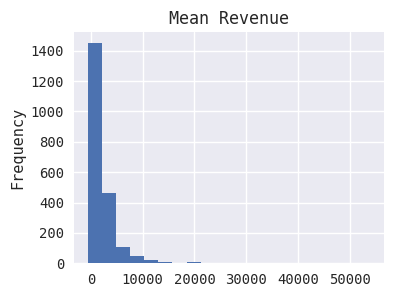

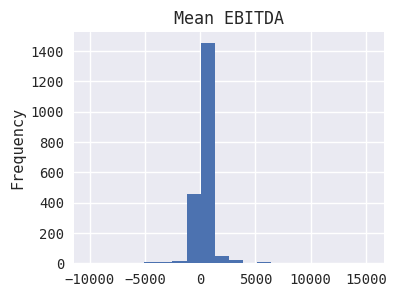

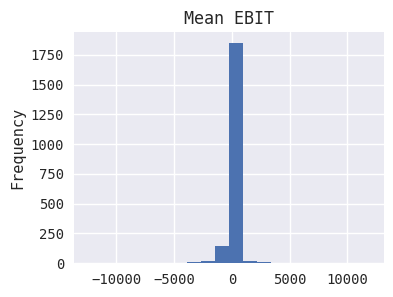

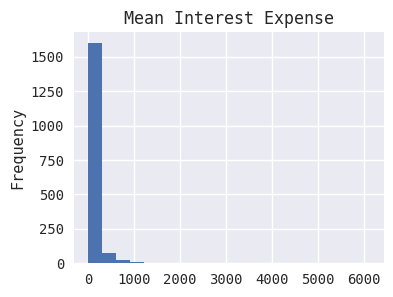

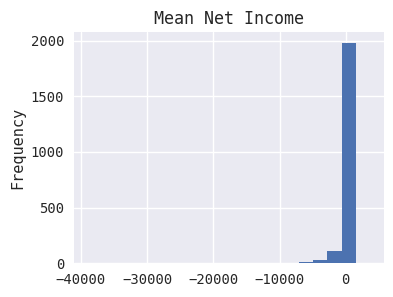

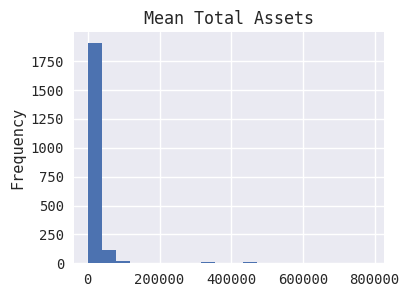

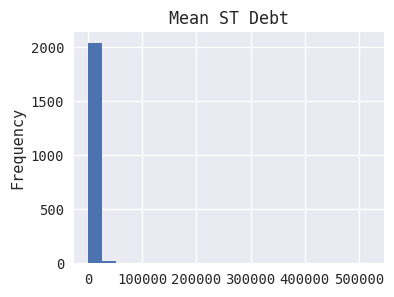

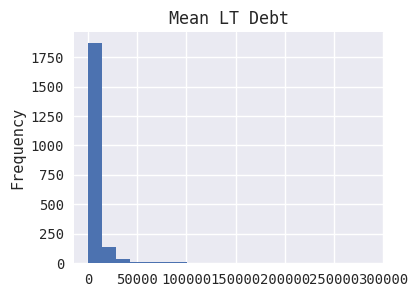

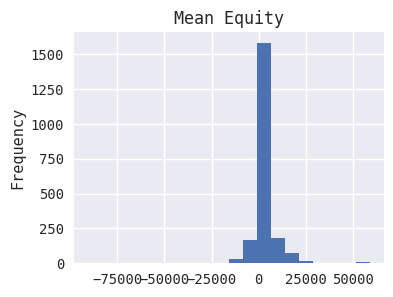

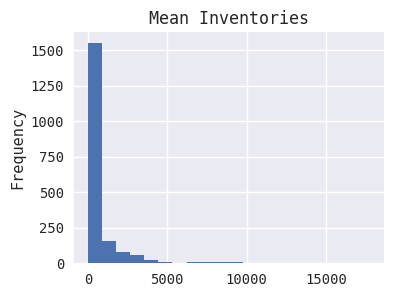

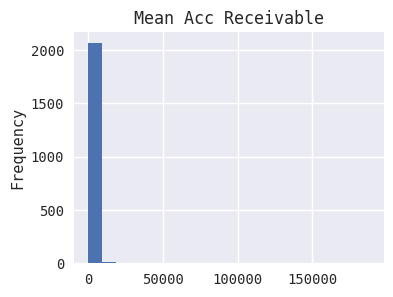

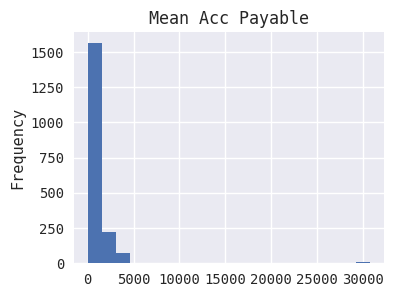

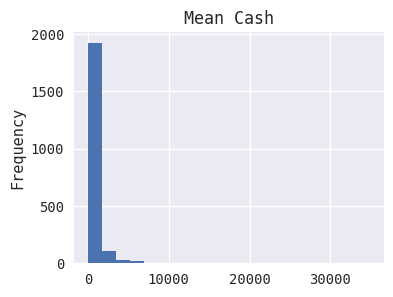

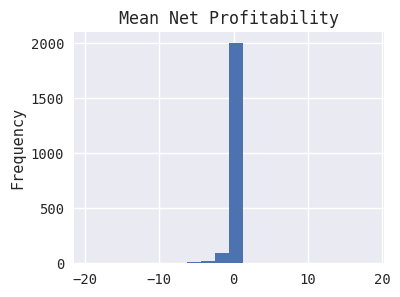

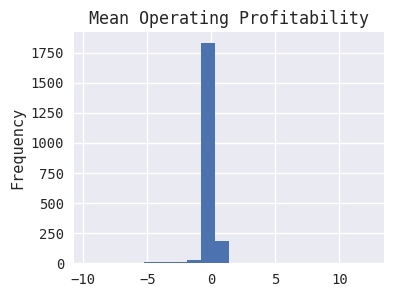

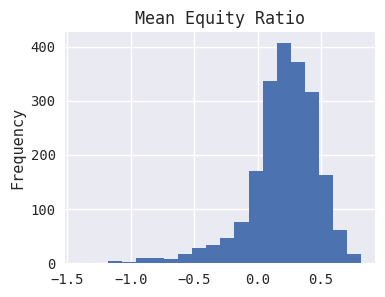

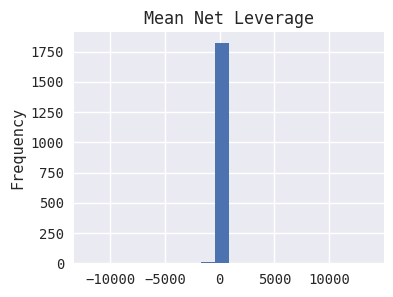

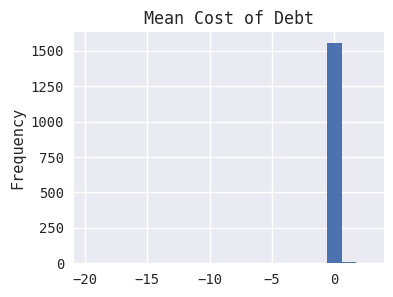

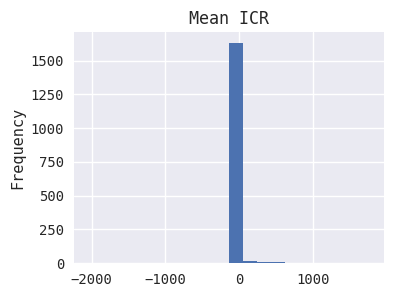

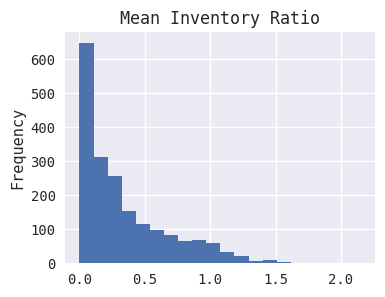

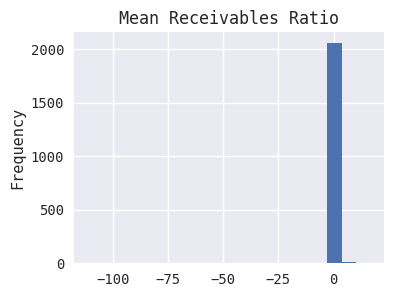

In [30]:
# --- Feature histograms ---
for col in frame.drop(columns=["Bankruptcy Countdown", "Bankruptcy Quarter", "BISC Code lvl1"]).columns:
    plt.figure(figsize=(4, 3))
    frame[col].dropna().plot(kind="hist", bins=20, title=f"Mean {col}")

### More features

In [31]:
dht(frame, 1)

,,Bankruptcy Countdown,Bankruptcy Quarter,BISC Code lvl1,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio
Short Ticker,Quarter,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1998Q1,-98,2022Q3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26385Z,2001Q1,-1,2001Q2,20,2562.0,-1203.0,-1420.0,201.0,-994.0,22455.0,5634.0,4978.0,793.0,284.0,1574.0,5226.0,154.0,-0.387978,-0.554254,0.035315,-4.349127,0.037319,-7.064677,0.110851,0.614364


In [32]:
# --- Time-related features ---

frame["Season"] = frame.index.get_level_values(1).str[-1].astype(int)

In [33]:
# - Shift a quarter back

# _df = frame.groupby("Short Ticker").shift(1)
# _df.columns = [f"{c} P1Q" for c in _df.columns]
# _df.loc["WNDXQ"]

# frame_ = pd.concat([frame, _df], axis=1)
# dht(frame_)

# print(frame_.loc["WNDXQ"].dropna(how="all"))

In [34]:
# TO DO: add more features

### Train and test sets

In [35]:
# --- Count valid samples ---

print(list(frame.columns))
dht(frame, 1)
_df = frame
print("all:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")
_df = frame.dropna(how="all", subset=list(narrow_sheets.keys()))
print("\ndrop rows with all NaNs:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")
_df = frame.dropna(how="any", subset=[x for x in _df.columns if not x.startswith("Bankruptcy ")])
print("\ndrop rows with any NaNs:")
print(f"n records = {len(_df)}")
print(f"n tickers = {_df.index.get_level_values(0).nunique()}")

['Bankruptcy Countdown', 'Bankruptcy Quarter', 'BISC Code lvl1', 'Revenue', 'EBITDA', 'EBIT', 'Interest Expense', 'Net Income', 'Total Assets', 'ST Debt', 'LT Debt', 'Equity', 'Inventories', 'Acc Receivable', 'Acc Payable', 'Cash', 'Net Profitability', 'Operating Profitability', 'Equity Ratio', 'Net Leverage', 'Cost of Debt', 'ICR', 'Inventory Ratio', 'Receivables Ratio', 'Season']


,,Bankruptcy Countdown,Bankruptcy Quarter,BISC Code lvl1,Revenue,EBITDA,EBIT,Interest Expense,Net Income,Total Assets,ST Debt,LT Debt,Equity,Inventories,Acc Receivable,Acc Payable,Cash,Net Profitability,Operating Profitability,Equity Ratio,Net Leverage,Cost of Debt,ICR,Inventory Ratio,Receivables Ratio,Season
Short Ticker,Quarter,,,,,,,,,,,,,,,,,,,,,,,,,
ENDPQ,1998Q1,-98,2022Q3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
26385Z,2001Q1,-1,2001Q2,20,2562.0,-1203.0,-1420.0,201.0,-994.0,22455.0,5634.0,4978.0,793.0,284.0,1574.0,5226.0,154.0,-0.387978,-0.554254,0.035315,-4.349127,0.037319,-7.064677,0.110851,0.614364,1


all:
n records = 4346
n tickers = 81

drop rows with all NaNs:
n records = 2141
n tickers = 81

drop rows with any NaNs:
n records = 1500
n tickers = 72


In [36]:
# --- Dividing tickers on train and test (by their bankruptcy quarter)

cutoff_quarter = "2016Q1"

frame_ = frame.dropna(how="any", subset=[x for x in _df.columns if not x.startswith("Bankruptcy ")])

# Bankcruptcy tickers
bankruptcy_quarters = (
    frame_.groupby("Short Ticker")["Bankruptcy Quarter"].last()
    .value_counts(sort=False).sort_index()
)
print(f"n companies overall = {bankruptcy_quarters.sum()}")
print(f"n companies recent = {bankruptcy_quarters[cutoff_quarter:].sum()}")

_b_train_tickers = set(
    frame_.loc[frame_["Bankruptcy Quarter"] < cutoff_quarter].index.get_level_values(0)
)
_b_test_tickers = set(
    frame_.loc[frame_["Bankruptcy Quarter"] >= cutoff_quarter].index.get_level_values(0)
)
print()
print(f"n bankcrupt train tickers = {len(_b_train_tickers)}")
print(f"n bankcrupt test tickers = {len(_b_test_tickers)}")

# Control tickers
_c_train_test_tickers = (
    frame_.loc[frame_["Bankruptcy Quarter"].isnull()].index.get_level_values(0).unique().values
)
np.random.shuffle(_c_train_test_tickers)
_n_c_train_tickers = int(
    len(_c_train_test_tickers) * len(_b_train_tickers) / (len(_b_train_tickers) + len(_b_test_tickers))
)
_c_train_tickers = set(_c_train_test_tickers[:_n_c_train_tickers])
_c_test_tickers = set(_c_train_test_tickers[_n_c_train_tickers:])
print(f"n control train tickers = {len(_c_train_tickers)}")
print(f"n control test tickers = {len(_c_test_tickers)}")

# Combined
train_tickers = _b_train_tickers | _c_train_tickers
test_tickers = _b_test_tickers | _c_test_tickers
print()
print(f"n train tickers = {len(train_tickers)}")
print(f"n test tickers = {len(test_tickers)}")

n companies overall = 72
n companies recent = 29

n bankcrupt train tickers = 43
n bankcrupt test tickers = 29
n control train tickers = 0
n control test tickers = 0

n train tickers = 43
n test tickers = 29


In [37]:
# --- Train and test datasets ---

frame_train = frame_.loc[
    frame_.index.get_level_values(0).isin(train_tickers)
    & (frame_.index.get_level_values(1) < cutoff_quarter)
].copy()
print(f'train: {frame_train["Bankruptcy Quarter"].dropna().min()}..{frame_train["Bankruptcy Quarter"].dropna().max()}')
X_train = frame_train.drop(columns=["Bankruptcy Quarter", "Bankruptcy Countdown"]).copy()
y_train = frame_train["Bankruptcy Countdown"].copy()
print(
    f"n pos train samples = {(y_train == -1).sum()} / {len(y_train)}"
    f" ({(y_train == -1).sum() / len(y_train):.3f})"
)

frame_test = frame_.loc[
    frame_.index.get_level_values(0).isin(test_tickers)
    # & (frame_.index.get_level_values(1) > cutoff_quarter)
].copy()
print(f'test: {frame_test["Bankruptcy Quarter"].dropna().min()}..{frame_test["Bankruptcy Quarter"].dropna().max()}')
X_test = frame_test.drop(columns=["Bankruptcy Quarter", "Bankruptcy Countdown"]).copy()
y_test = frame_test["Bankruptcy Countdown"].copy()
print(
    f"n pos test samples = {(y_test == -1).sum()} / {len(y_test)}"
    f" ({(y_test == -1).sum() / len(y_test):.3f})"
)

train: 2001Q2..2015Q3
n pos train samples = 33 / 699 (0.047)
test: 2016Q1..2022Q3
n pos test samples = 15 / 801 (0.019)


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


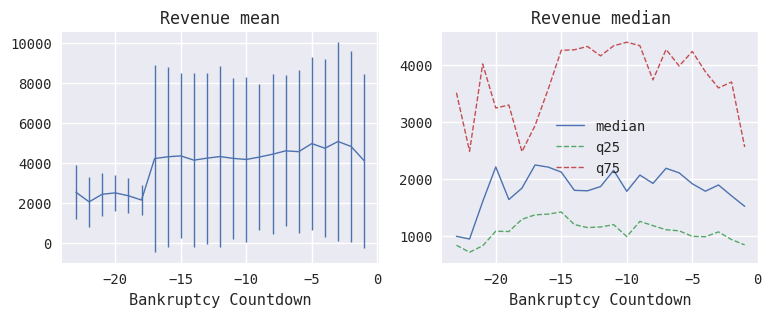

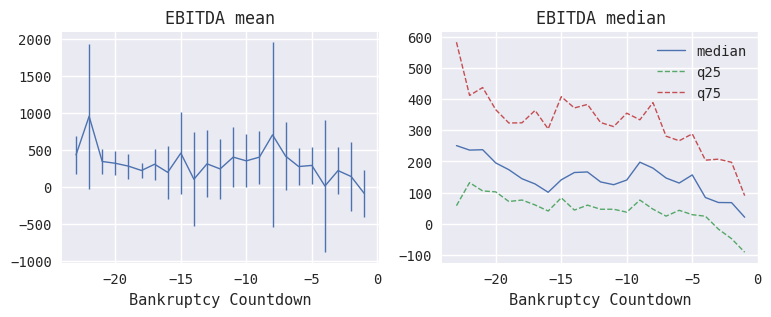

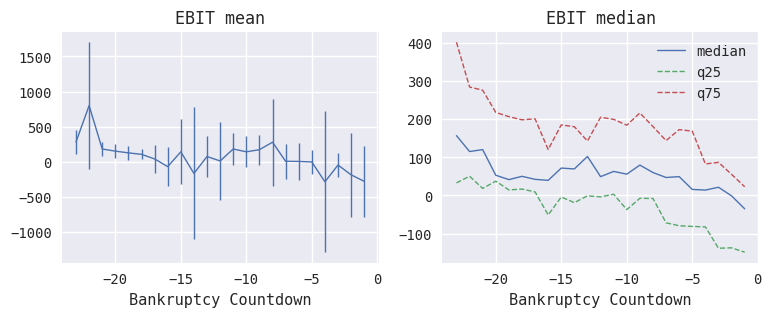

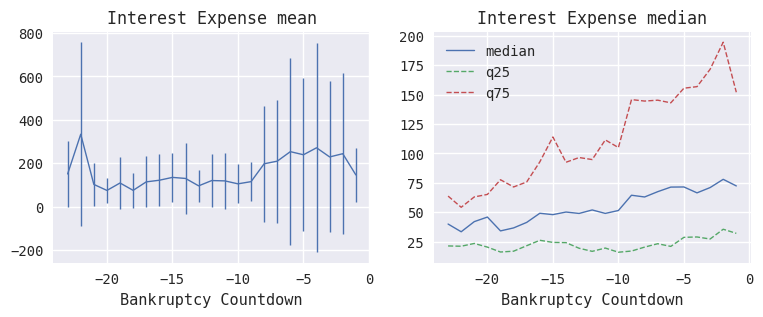

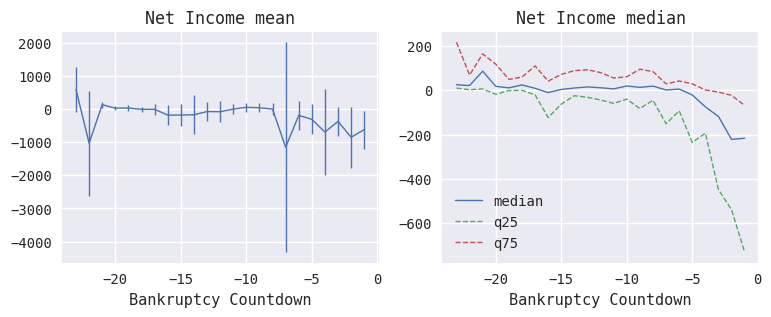

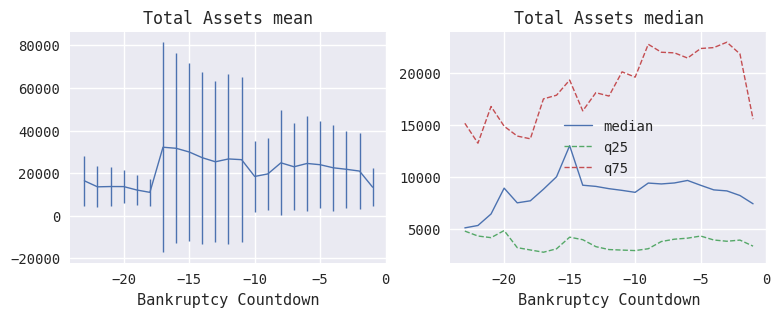

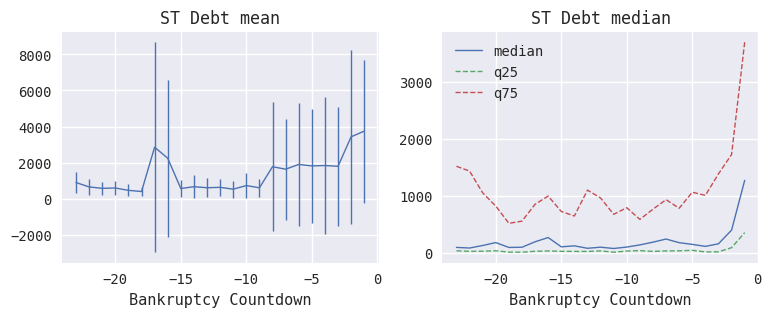

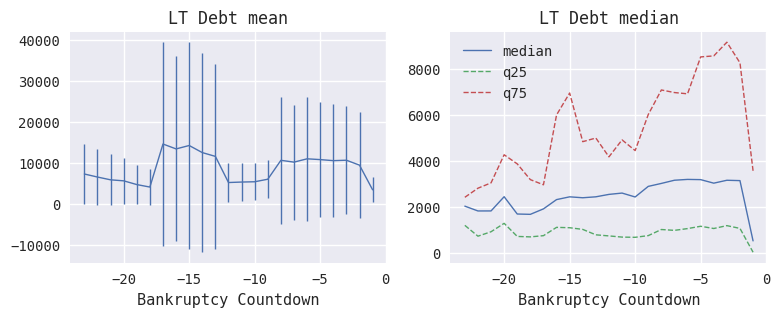

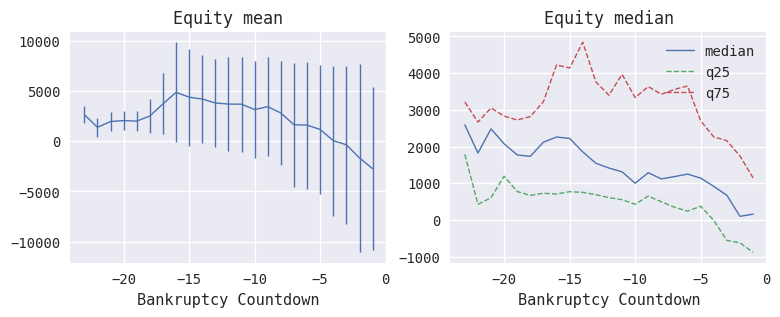

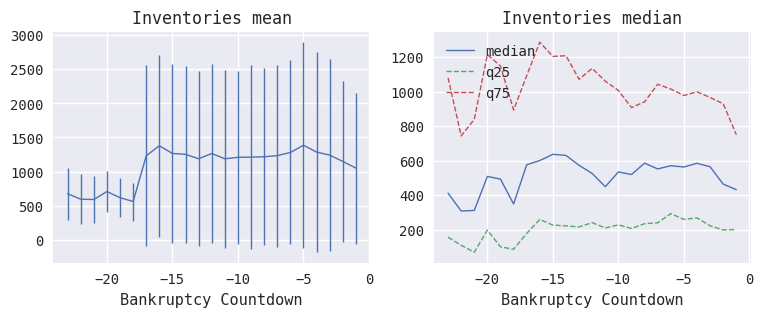

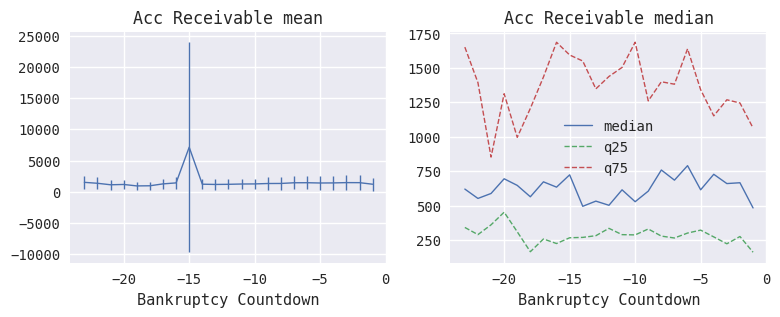

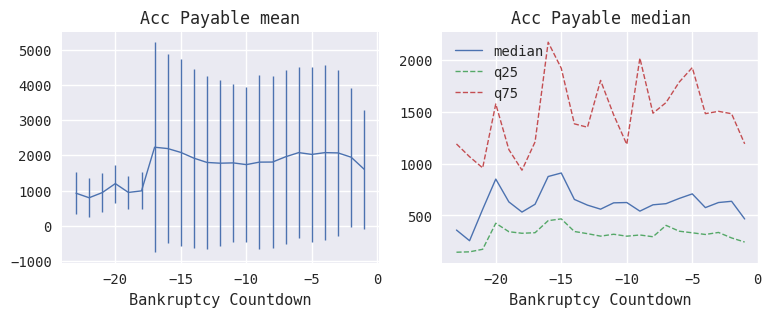

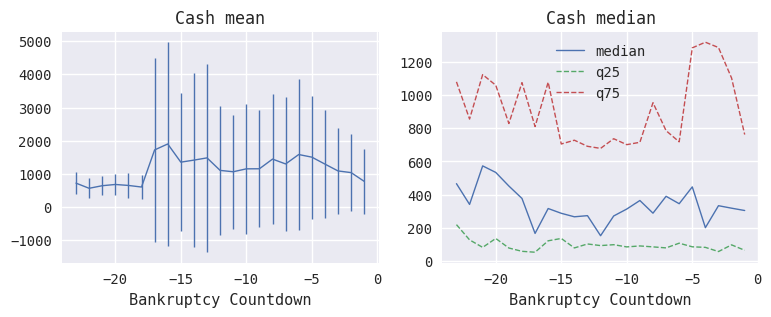

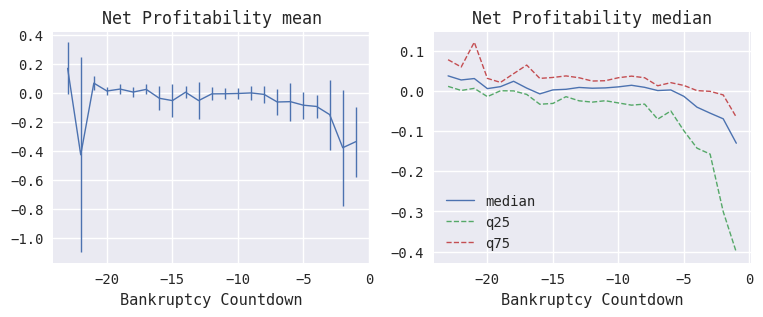

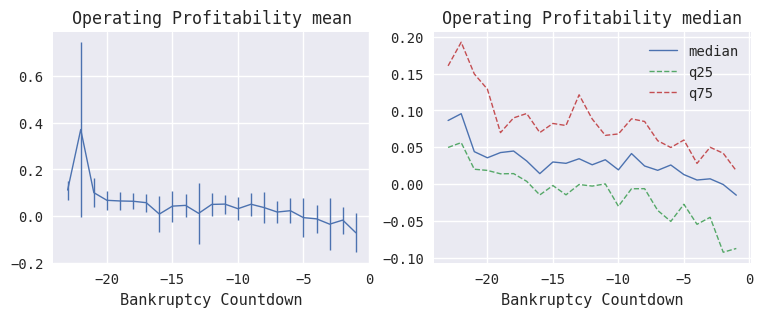

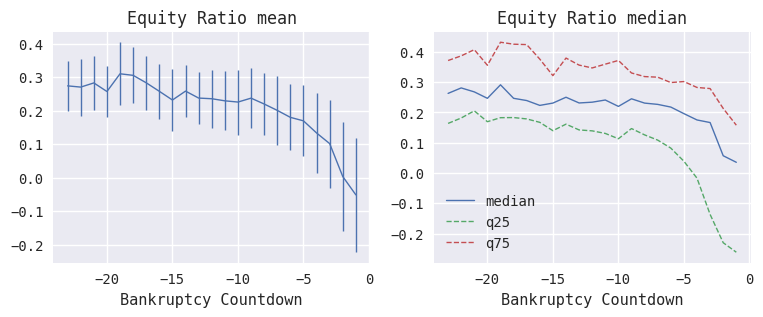

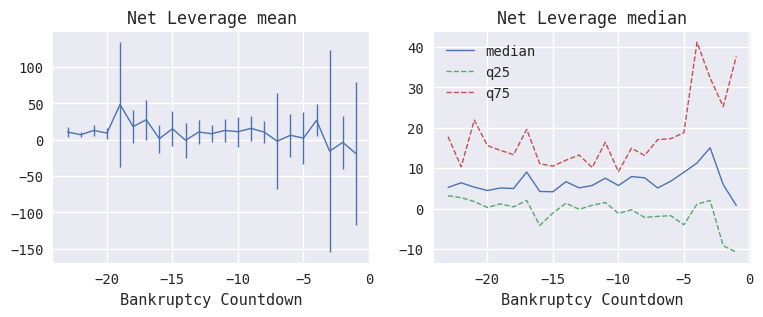

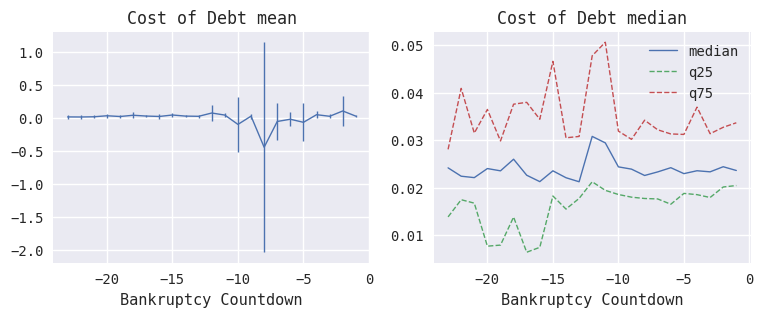

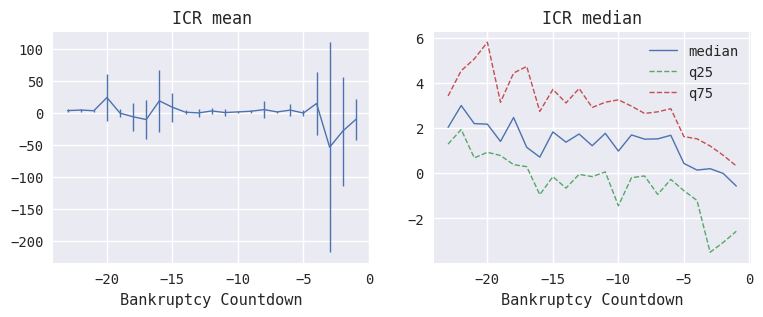

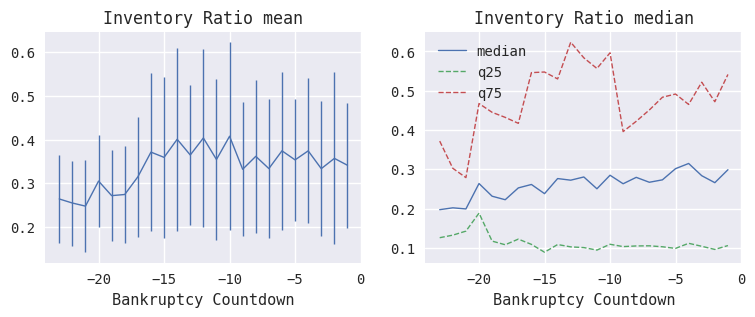

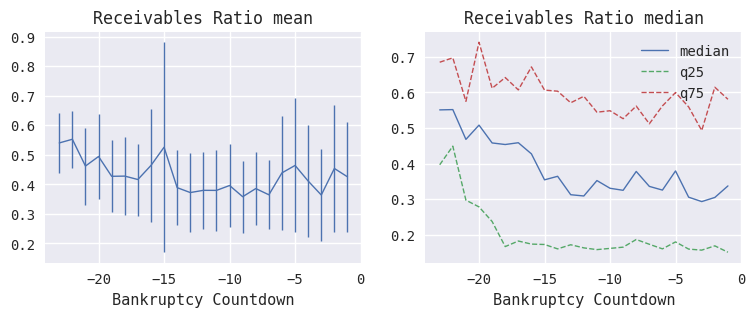

In [38]:
# --- Plotting dependencies ---

for col in X_train.drop(columns=["BISC Code lvl1", "Season"]).columns:
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    _agg = frame_train.groupby("Bankruptcy Countdown")[col].agg(
        ["mean", "median", "std", q25, q75, "count"]
    )
    _agg = _agg.loc[_agg["count"] > 5]
    _agg["mean"].plot(title=f"{col} mean", ax=ax[0], yerr=_agg["std"] / 2)
    _agg[["median"]].plot(title=f"{col} median", ax=ax[1])
    _agg[["q25", "q75"]].plot(ax=ax[1], linestyle="--")
_ = _

## Hypothesis 0: We can predict bankcruptcy in the next quarter

- 1 = Bankruptcy next quarter
- 0 = Okay next quarter

In [39]:
def classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat=None, p_test_hat=None,
):
    # mean of sensitivity (TPR) and specificity (TNR)
    print(f"b acc train = {balanced_accuracy_score(y_train_.values, y_train_hat):.2}")
    print(f"b acc test  = {balanced_accuracy_score(y_test_.values, y_test_hat):.2}")
    
    # precision and recall (TPR)
    print()
    print(f"precision train = {precision_score(y_train_.values, y_train_hat):.2}")
    print(f"precision test  = {precision_score(y_test_.values, y_test_hat):.2}")
    print(f"recall train = {recall_score(y_train_.values, y_train_hat):.2}")
    print(f"recall test  = {recall_score(y_test_.values, y_test_hat):.2}")

    # confusion matrix
    print(f"\nconfusion train:")
    print(confusion_matrix(y_train_.values, y_train_hat))
    print(f"\nconfusion test:")
    print(confusion_matrix(y_test_.values, y_test_hat))
    
    # ROC curve plot
    if (p_train_hat is not None) and (p_test_hat is not None):
        _ = RocCurveDisplay.from_predictions(y_train_.values, p_train_hat)


### Logistic regression

In [40]:
def preprocess_X(X):
    return X.drop(columns=["BISC Code lvl1", "Season"])


def preprocess_y(y):
    return (y.replace(pd.NA, -100) == -1).astype(int)

b acc train = 0.54
b acc test  = 0.75

precision train = 0.43
precision test  = 0.22
recall train = 0.091
recall test  = 0.53

confusion train:
[[662   4]
 [ 30   3]]

confusion test:
[[758  28]
 [  7   8]]



intercept          -3.95
LT Debt            -1.08
Equity Ratio       -0.99
Cash               -0.94
Total Assets       -0.78
ST Debt             0.68
EBITDA             -0.65
Revenue             0.64
Interest Expense   -0.47
Net Income          0.42
dtype: float64

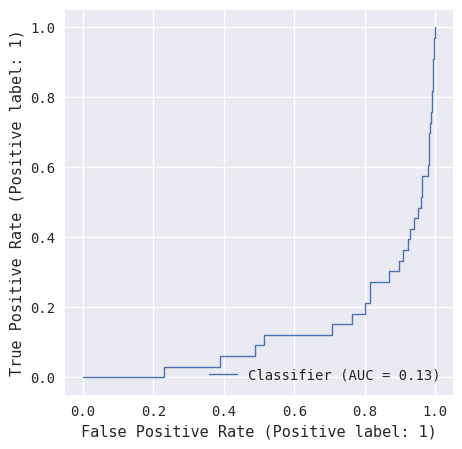

In [41]:
# --- Logistic: No weights ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l2", class_weight=None)),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.83
b acc test  = 0.87

precision train = 0.23
precision test  = 0.081
recall train = 0.79
recall test  = 0.93

confusion train:
[[581  85]
 [  7  26]]

confusion test:
[[628 158]
 [  1  14]]



ST Debt           2.78
intercept        -1.64
LT Debt          -1.64
Cash             -1.60
Acc Payable      -1.52
Acc Receivable   -1.37
Total Assets     -1.37
EBITDA           -1.27
Equity Ratio     -1.10
Revenue           0.93
dtype: float64

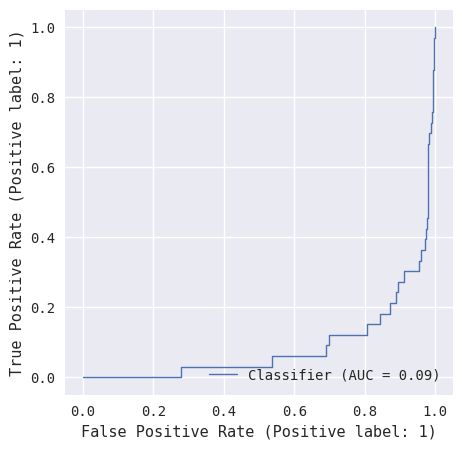

In [42]:
# --- Logistic: Balanced weights ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l2", class_weight="balanced")),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.77
b acc test  = 0.8

precision train = 0.15
precision test  = 0.06
recall train = 0.76
recall test  = 0.87

confusion train:
[[526 140]
 [  8  25]]

confusion test:
[[582 204]
 [  2  13]]



Equity Ratio              -0.61
intercept                 -0.38
Net Profitability         -0.30
Operating Profitability   -0.29
LT Debt                   -0.27
Season                     0.19
Cash                      -0.14
ST Debt                    0.05
Receivables Ratio          0.00
Inventory Ratio            0.00
dtype: float64

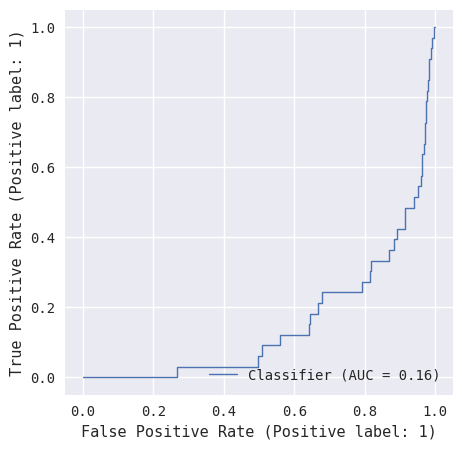

In [48]:
# --- Logistic: Balanced weights + Manual L1 regularization ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = Pipeline((
    ("s", StandardScaler()),
    ("e", LogisticRegression(penalty="l1", C=0.05, class_weight="balanced", solver="liblinear")),
))
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
display(pd.Series(
    np.concatenate([m.named_steps["e"].coef_[0], [m.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

b acc train = 0.82
b acc test  = 0.87

precision train = 0.23
precision test  = 0.085
recall train = 0.76
recall test  = 0.93

confusion train:
[[582  84]
 [  8  25]]

confusion test:
[[636 150]
 [  1  14]]

LogisticRegression(C=0.2, class_weight='balanced', penalty='l1',
                   solver='liblinear')


LT Debt                   -2.06
ST Debt                    1.20
Cash                      -1.09
intercept                 -0.97
Equity Ratio              -0.83
Net Profitability         -0.44
Operating Profitability   -0.24
Receivables Ratio         -0.23
Inventories                0.22
Revenue                    0.21
dtype: float64

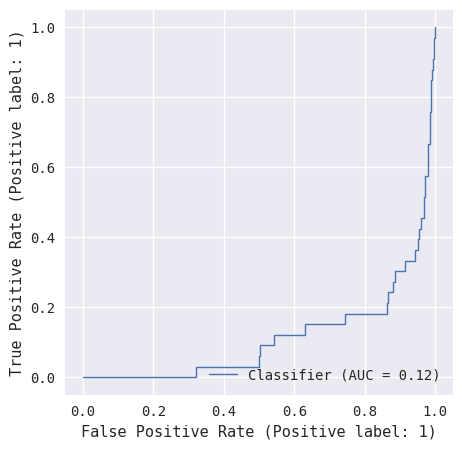

In [44]:
# --- Logistic: Balanced weights + Auto L1 regularization ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = GridSearchCV(
    Pipeline((
        ("s", StandardScaler()),
        ("e", LogisticRegression(penalty="l1", class_weight="balanced", solver="liblinear")),
    )),
    {
        'e__C': [0.05, 0.01, 0.2, 0.5, 1.0],
    },
    scoring="balanced_accuracy",
    cv=5,
)
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
p_train_hat = m.predict_proba(X_train_)[:, 0]
y_test_hat = m.predict(X_test_)
p_test_hat = m.predict_proba(X_test_)[:, 0]

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat, p_train_hat, p_test_hat
)

print()
best = m.best_estimator_
print(best.named_steps["e"])
display(pd.Series(
    np.concatenate([best.named_steps["e"].coef_[0], [best.named_steps["e"].intercept_[0]]]).round(2), 
    index=np.concatenate([X_train_.columns, ['intercept']])
).sort_values(key=lambda x: -abs(x)).head(10))

### GB Trees

In [45]:
def preprocess_X(X):
    X = X.copy()
    X["BISC Code lvl1"] =  X["BISC Code lvl1"].astype('category')
    X["Season"] =  X["Season"].astype('category')
    return X


def preprocess_y(y):
    return (y.replace(pd.NA, -100) == -1).astype(int)

b acc train = 0.87
b acc test  = 0.79

precision train = 0.29
precision test  = 0.12
recall train = 0.85
recall test  = 0.67

confusion train:
[[599  67]
 [  5  28]]

confusion test:
[[716  70]
 [  5  10]]

LGBMClassifier(class_weight='balanced', learning_rate=0.03, min_child_samples=5,
               num_leaves=3, objective='cross_entropy', reg_lambda=0.3)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


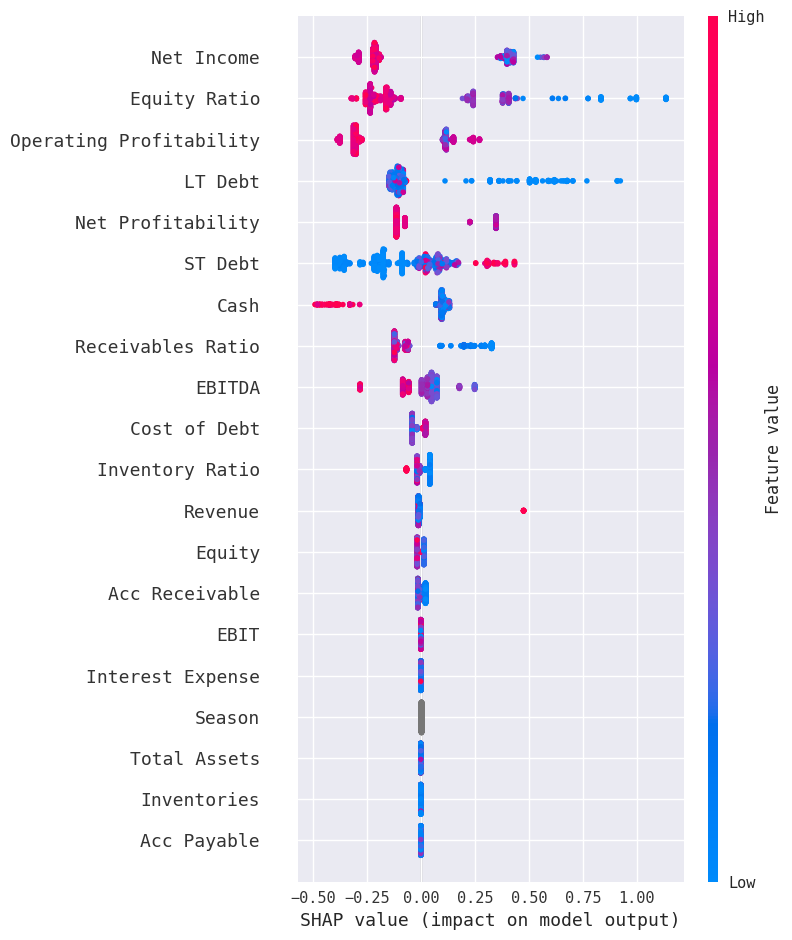

In [46]:
# --- GB Trees: Balanced weights + Auto hyper-parameter tuning ---

X_train_ = preprocess_X(X_train)
y_train_ = preprocess_y(y_train)
X_test_ = preprocess_X(X_test)
y_test_ = preprocess_y(y_test)


m = GridSearchCV(
    LGBMClassifier(
        n_estimators=100, 
        min_child_samples=5,
        objective="cross_entropy",
        class_weight="balanced",
    ),
    {
        'num_leaves': [15, 7, 3],
        'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
        'reg_lambda': [0.003, 0.01, 0.3, 1.],
    },
    scoring="balanced_accuracy",
    cv=5,
)
m.fit(X_train_, y_train_)
y_train_hat = m.predict(X_train_)
y_test_hat = m.predict(X_test_)

classification_results(
    y_train_, y_test, y_train_hat, y_test_hat
)

print()
best = m.best_estimator_
print(best)

# explainer = shap.TreeExplainer(best, X_train_)  # DOES NOT WORK DUE TO A SHAP BUG
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(X_test_, y_test_)
shap.summary_plot(shap_values, X_test_)